# MBTI Prediction - Strategy 2
In this notebook, we will train a classification model for each category and not only one to directly predict the full MBTI type.

## Libraries

In [18]:
from itertools import islice 
from joblib import dump, load
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

## Data import

In [2]:
df = pd.read_csv('../mbti_data.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
df.shape

(8675, 2)

## Data preprocessing

Split each line (~50 posts) into subline (5 posts).

In [9]:
def dataframe_split(df, n=5):
    df_r = pd.DataFrame(columns=['type','posts'])
    for i in range(len(df)):
        full_list = df.loc[i, 'posts'].split('|||')
        sub_list = [full_list[i:i+n] for i in range(0, len(full_list),n)]
        for j in sub_list:
            df_r = df_r.append({'type': df.loc[i, 'type'], 'posts': ' '.join(j)}, ignore_index=True)
    return df_r

In [10]:
%%time
df = dataframe_split(df)

Wall time: 3min 46s


In [11]:
df.shape

(85017, 2)

In [12]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1,INFJ,May the PerC Experience immerse you. The last ...
2,INFJ,http://playeressence.com/wp-content/uploads/20...
3,INFJ,https://www.youtube.com/watch?v=QyPqT8umzmY It...
4,INFJ,Yo entp ladies... if you're into a complimenta...


First, we prepare our targets. We will have one classifier to predict the "target_ie" value, one for "target_sn", one for "target_tf" and one for "target_jp".

In [13]:
df['target_ie'] = df['type'].apply(lambda row: row[0])
df['target_sn'] = df['type'].apply(lambda row: row[1])
df['target_tf'] = df['type'].apply(lambda row: row[2])
df['target_jp'] = df['type'].apply(lambda row: row[3])
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,I,N,F,J
1,INFJ,May the PerC Experience immerse you. The last ...,I,N,F,J
2,INFJ,http://playeressence.com/wp-content/uploads/20...,I,N,F,J
3,INFJ,https://www.youtube.com/watch?v=QyPqT8umzmY It...,I,N,F,J
4,INFJ,Yo entp ladies... if you're into a complimenta...,I,N,F,J


Let's see the distribition of the new variables created.

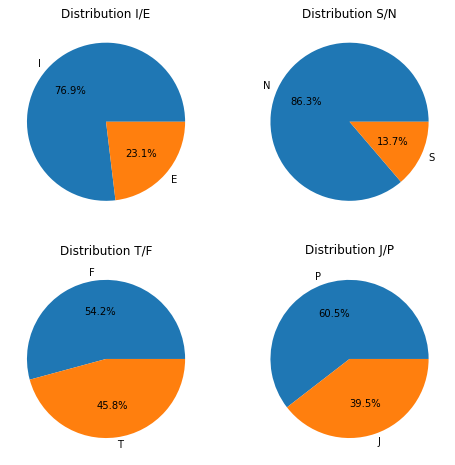

In [14]:
ie_dist = df['target_ie'].value_counts().rename_axis('types').reset_index(name='counts')
sn_dist = df['target_sn'].value_counts().rename_axis('types').reset_index(name='counts')
tf_dist = df['target_tf'].value_counts().rename_axis('types').reset_index(name='counts')
jp_dist = df['target_jp'].value_counts().rename_axis('types').reset_index(name='counts')

fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].pie(ie_dist['counts'], labels=ie_dist['types'], autopct='%1.1f%%')
axs[0, 0].set_title('Distribution I/E')
axs[0, 1].pie(sn_dist['counts'], labels=sn_dist['types'], autopct='%1.1f%%')
axs[0, 1].set_title('Distribution S/N')
axs[1, 0].pie(tf_dist['counts'], labels=tf_dist['types'], autopct='%1.1f%%')
axs[1, 0].set_title('Distribution T/F')
axs[1, 1].pie(jp_dist['counts'], labels=jp_dist['types'], autopct='%1.1f%%')
axs[1, 1].set_title('Distribution J/P')
plt.show()

F1-score

Let's preprocess the data.

In [15]:
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

def preprocessing(text, stemming_on=False, stop_words=stop_words, porter_stemmer=porter_stemmer):
    text = text.lower()                                          # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)                  # Noise removal (regex to remove punctuations)
    text = text.strip()                                          # Noise removal (extra spaces)
    words = text.split()                                         # Split sentence into list of words
    words = [w for w in words if not w in stop_words]            # Stopwords removal
    if(stemming_on):
        words = [porter_stemmer.stem(word) for word in words]    # Replace the word by its stem
    text = ' '.join(words)                                       # Transform list of words to str
    return text

In [16]:
%%time
df['posts_preproc'] = df['posts'].apply(lambda row: preprocessing(row, stemming_on=True))

Wall time: 1min 48s


In [17]:
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp,posts_preproc
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,I,N,F,J,http www youtub com watch v qsxhcwe3krw http 4...
1,INFJ,May the PerC Experience immerse you. The last ...,I,N,F,J,may perc experi immers last thing infj friend ...
2,INFJ,http://playeressence.com/wp-content/uploads/20...,I,N,F,J,http playeress com wp content upload 2013 08 r...
3,INFJ,https://www.youtube.com/watch?v=QyPqT8umzmY It...,I,N,F,J,http www youtub com watch v qypqt8umzmi appear...
4,INFJ,Yo entp ladies... if you're into a complimenta...,I,N,F,J,yo entp ladi complimentari person well hey mai...


## Vectorization

In [24]:
c_vectorizer = CountVectorizer()
ti_vectorizer = TfidfVectorizer()

In [25]:
c_X = c_vectorizer.fit_transform(df['posts_preproc'])
ti_X = ti_vectorizer.fit_transform(df['posts_preproc'])

## Analysis - Best configuration

In [74]:
config = {
    'data_vect': {
        'CountVectorizer': c_X,
        'TfidfVectorizer': ti_X
    },
    'classifier': {
        'LinearSVC': LinearSVC(class_weight='balanced', random_state=14, max_iter=50000), 
        'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=14, max_iter=50000)
    }
}

In [75]:
def training_analysis(df, config, target):
    for vectorizer in config['data_vect']:
        X_train, X_test, y_train, y_test = train_test_split(config['data_vect'][vectorizer], df[target], test_size=0.2, random_state=14)
        for classifier in config['classifier']:
            config['classifier'][classifier].fit(X_train, y_train)
            print(f'{vectorizer} | {classifier}:')
            print(f'____________________________\n')
            y_pred = config['classifier'][classifier].predict(X_test)
            print(f'{classification_report(y_test, y_pred)}\n')
            print(f'------------------------------------------------------------------------\n')

 ### Target I/E

In [76]:
training_analysis(df, config, 'target_ie')

CountVectorizer | LinearSVC:
____________________________

              precision    recall  f1-score   support

           E       0.37      0.45      0.40      3893
           I       0.82      0.77      0.80     13111

    accuracy                           0.70     17004
   macro avg       0.60      0.61      0.60     17004
weighted avg       0.72      0.70      0.71     17004


------------------------------------------------------------------------

CountVectorizer | LogisticRegression:
____________________________

              precision    recall  f1-score   support

           E       0.40      0.52      0.45      3893
           I       0.84      0.77      0.81     13111

    accuracy                           0.71     17004
   macro avg       0.62      0.64      0.63     17004
weighted avg       0.74      0.71      0.73     17004


------------------------------------------------------------------------

TfidfVectorizer | LinearSVC:
____________________________

          

### Target S/N

In [77]:
training_analysis(df, config, 'target_sn')

CountVectorizer | LinearSVC:
____________________________

              precision    recall  f1-score   support

           N       0.89      0.84      0.87     14612
           S       0.28      0.37      0.32      2392

    accuracy                           0.78     17004
   macro avg       0.59      0.61      0.59     17004
weighted avg       0.81      0.78      0.79     17004


------------------------------------------------------------------------

CountVectorizer | LogisticRegression:
____________________________

              precision    recall  f1-score   support

           N       0.90      0.83      0.86     14612
           S       0.30      0.46      0.36      2392

    accuracy                           0.77     17004
   macro avg       0.60      0.64      0.61     17004
weighted avg       0.82      0.77      0.79     17004


------------------------------------------------------------------------

TfidfVectorizer | LinearSVC:
____________________________

          

### Target T/F

In [78]:
training_analysis(df, config, 'target_tf')

CountVectorizer | LinearSVC:
____________________________

              precision    recall  f1-score   support

           F       0.70      0.68      0.69      9226
           T       0.63      0.65      0.64      7778

    accuracy                           0.67     17004
   macro avg       0.66      0.66      0.66     17004
weighted avg       0.67      0.67      0.67     17004


------------------------------------------------------------------------

CountVectorizer | LogisticRegression:
____________________________

              precision    recall  f1-score   support

           F       0.73      0.71      0.72      9226
           T       0.67      0.69      0.68      7778

    accuracy                           0.70     17004
   macro avg       0.70      0.70      0.70     17004
weighted avg       0.70      0.70      0.70     17004


------------------------------------------------------------------------

TfidfVectorizer | LinearSVC:
____________________________

          

### Target J/P

In [79]:
training_analysis(df, config, 'target_jp')

CountVectorizer | LinearSVC:
____________________________

              precision    recall  f1-score   support

           J       0.52      0.55      0.53      6746
           P       0.69      0.66      0.68     10258

    accuracy                           0.62     17004
   macro avg       0.60      0.61      0.60     17004
weighted avg       0.62      0.62      0.62     17004


------------------------------------------------------------------------

CountVectorizer | LogisticRegression:
____________________________

              precision    recall  f1-score   support

           J       0.55      0.59      0.57      6746
           P       0.72      0.68      0.70     10258

    accuracy                           0.65     17004
   macro avg       0.63      0.64      0.63     17004
weighted avg       0.65      0.65      0.65     17004


------------------------------------------------------------------------

TfidfVectorizer | LinearSVC:
____________________________

          

## Training

### Target I/E

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_ie'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_ie'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_ie.joblib') 

 ### Target S/N

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_sn'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_sn'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_sn.joblib') 

 ### Target T/F

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_tf'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_tf'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_tf.joblib') 

 ### Target J/P

In [ ]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_jp'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_jp'], test_size=0.2, random_state=14)

In [ ]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

In [ ]:
dump(ti_clf, '../models/model_jp.joblib') 

## Prediction

In [ ]:
clf_ie = load('../models/model_ie.joblib')
clf_sn = load('../models/model_sn.joblib')
clf_tf = load('../models/model_tf.joblib')
clf_jp = load('../models/model_jp.joblib')
print('Models loaded!')

In [ ]:
test_string = ['what am I going to do during this lockdown maybe think about a new business']
test_string_vect = ti_vectorizer.transform(test_string)
print(test_string_vect)

In [ ]:
result_ie = clf_ie.predict(test_string_vect)
result_sn = clf_sn.predict(test_string_vect)
result_tf = clf_tf.predict(test_string_vect)
result_jp = clf_jp.predict(test_string_vect)

In [ ]:
print(f'MBTI type: {result_ie[0]}{result_sn[0]}{result_tf[0]}{result_jp[0]}')